In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# general theme
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [3]:
# Read Results
batch_all = pd.read_csv(r"SVM-2-Report_09-17-24_2.csv",encoding="latin-1") # Please change the file path
batch_all

,Glucose,Sucrose,Total Sugar,pH,Fold Increase,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,0,0,0,lo,1.57,NaN,NaN,NaN,Glucose,Sucrose,Total Sugar,pH,Fold Increase
1,0,10,10,lo,6.45,NaN,NaN,Control,20,0,20,md,30.33
2,0,20,20,lo,5.09,NaN,NaN,Opt Media 1,10,10,20,md,31.02
3,0,30,30,lo,4.65,NaN,NaN,Opt Media 2,10,10,20,hi,31.32
4,0,40,40,lo,7.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,40,0,40,hi,32.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,40,10,50,hi,29.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,40,20,60,hi,24.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,40,30,70,hi,25.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Seperate Data to Low, Medium, and High pH Groups.
batch_lo = batch_all[batch_all["pH"] == "lo"]
batch_md = batch_all[batch_all["pH"] == "md"]
batch_hi = batch_all[batch_all["pH"] == "hi"]

In [5]:
# Select columns for SVR
x_cols = ["Glucose", "Sucrose"]
y_cols = ["Fold Increase"]

# Train Test Split - Low pH
x_train_lo, x_test_lo, y_train_lo, y_test_lo = train_test_split(batch_lo[x_cols], batch_lo[y_cols], test_size=0.1, random_state=1)

# Train Test Split - Med. pH
x_train_md, x_test_md, y_train_md, y_test_md = train_test_split(batch_md[x_cols], batch_md[y_cols], test_size=0.1, random_state=1)

# Train Test Split - High pH
x_train_hi, x_test_hi, y_train_hi, y_test_hi = train_test_split(batch_hi[x_cols], batch_hi[y_cols], test_size=0.1, random_state=10)

In [9]:
# Alternate Training use all the training data to train the model without splitting
x_all_lo=batch_lo[x_cols]
y_all_lo=batch_lo[y_cols]

x_all_md=batch_md[x_cols]
y_all_md=batch_md[y_cols]

x_all_hi=batch_hi[x_cols]
y_all_hi=batch_hi[y_cols]

In [10]:
# Define Scaler for Normalizing x data
scalerG = np.max(batch_all["Glucose"], axis=0) # Since the Sucrose's max concentration is the same as glucose, no need to define sucrose scaler
print(scalerG)

# Normalize x data
x_train_lo_nor = np.array(x_train_lo / scalerG)
x_test_lo_nor = np.array(x_test_lo / scalerG)
x_all_lo_nor = np.array(x_all_lo / scalerG)

x_train_md_nor = np.array(x_train_md / scalerG)
x_test_md_nor = np.array(x_test_md / scalerG)
x_all_md_nor = np.array(x_all_md / scalerG)

x_train_hi_nor = np.array(x_train_hi / scalerG)
x_test_hi_nor = np.array(x_test_hi / scalerG)
x_all_hi_nor = np.array(x_all_hi / scalerG)

# Define the scaler for y data
scaler_y_lo = max(batch_lo['Fold Increase'])
scaler_y_md = max(batch_md['Fold Increase'])
scaler_y_hi = max(batch_hi['Fold Increase'])

# Array y data
y_train_lo_a = np.array(y_train_lo / scaler_y_lo)
y_test_lo_a = np.array(y_test_lo / scaler_y_lo)
y_all_lo_a = np.array(y_all_lo / scaler_y_lo)

y_train_md_a = np.array(y_train_md / scaler_y_md)
y_test_md_a = np.array(y_test_md / scaler_y_md)
y_all_md_a = np.array(y_all_md / scaler_y_md)

y_train_hi_a = np.array(y_train_hi / scaler_y_hi)
y_test_hi_a = np.array(y_test_hi / scaler_y_hi)
y_all_hi_a = np.array(y_all_hi / scaler_y_hi)


40


In [11]:
def find_best_params(x_train, x_test, y_train, y_test, C_value=np.logspace(-1, 5, 7), g_value = np.logspace(2, -4, 7), kernel='rbf'):

    C_value = C_value
    g_value = g_value
    results = {}

    for i in C_value:
        for j in g_value:

            # Define the model SVR model for low pH
            svr_lo = SVR(kernel=kernel, C=i, gamma=j)  # Best parameters according to GridSearchCV()

            # Traing SVR model
            svr_lo.fit(x_train, y_train)

            # Make predictions on the training data and calculate MAE
            y_train_pred = svr_lo.predict(x_train)
            mae_train = mean_absolute_error(y_train, y_train_pred)

            # Make predictions on the training data and calculate MAE
            y_test_pred = svr_lo.predict(x_test)
            mae_test = mean_absolute_error(y_test, y_test_pred)

            # Calculate R square
            r2 = round(svr_lo.score(x_train, y_train.ravel()), 4)

            results[(i, j)] = r2

    # Find max R2
    max_r2 = max(results.values())
    best_params = [params for params, r2 in results.items() if r2 == max_r2]
    best_C, best_gamma = best_params[0]
    
    print(f"Best C and gamma based on max r2: {best_params[0]} with r2: {max_r2}")
    
    return best_C, best_gamma

In [12]:
# Select C and gamma based on R square
C_lo, gamma_lo = find_best_params(x_train_lo_nor, x_test_lo_nor, y_train_lo_a.ravel(), y_test_lo_a.ravel())
C_md, gamma_md = find_best_params(x_train_md_nor, x_test_md_nor, y_train_md_a.ravel(), y_test_md_a.ravel())
C_hi, gamma_hi = find_best_params(x_train_hi_nor, x_test_hi_nor, y_train_hi_a.ravel(), y_test_hi_a.ravel())

Best C and gamma based on max r2: (1.0, 10.0) with r2: 0.8179
Best C and gamma based on max r2: (100000.0, 0.1) with r2: 0.8569
Best C and gamma based on max r2: (100.0, 1.0) with r2: 0.8741


In [13]:
C_lo, gamma_lo = find_best_params(x_all_lo_nor, x_test_lo_nor, y_all_lo_a.ravel(), y_test_lo_a.ravel())
C_md, gamma_md = find_best_params(x_all_md_nor, x_test_md_nor, y_all_md_a.ravel(), y_test_md_a.ravel())
C_hi, gamma_hi = find_best_params(x_all_hi_nor, x_test_hi_nor, y_all_hi_a.ravel(), y_test_hi_a.ravel())

Best C and gamma based on max r2: (1.0, 10.0) with r2: 0.8326
Best C and gamma based on max r2: (100.0, 1.0) with r2: 0.8512
Best C and gamma based on max r2: (100.0, 1.0) with r2: 0.8531


In [14]:
# Build 3 SVR models
svr_lo = SVR(kernel='rbf', C=C_lo, gamma=gamma_lo)
svr_lo.fit(x_train_lo_nor, y_train_lo_a.ravel())

svr_md = SVR(kernel='rbf', C=C_md, gamma=gamma_md)
svr_md.fit(x_train_md_nor, y_train_md_a.ravel())

svr_hi = SVR(kernel='rbf', C=C_hi, gamma=gamma_hi)
svr_hi.fit(x_train_hi_nor, y_train_hi_a.ravel())

SVR(C=100.0, gamma=1.0)

In [15]:
# Build 3 SVR models
svr_lo = SVR(kernel='rbf', C=C_lo, gamma=gamma_lo)
svr_lo.fit(x_all_lo_nor, y_all_lo_a.ravel())

svr_md = SVR(kernel='rbf', C=C_md, gamma=gamma_md)
svr_md.fit(x_all_md_nor, y_all_md_a.ravel())

svr_hi = SVR(kernel='rbf', C=C_hi, gamma=gamma_hi)
svr_hi.fit(x_all_hi_nor, y_all_hi_a.ravel())

SVR(C=100.0, gamma=1.0)

In [16]:
# Creating data for model to predict and condtruct 2D heatmap
gd_num = 401


xx = np.linspace(0, 40, gd_num)
yy = np.linspace(0, 40, gd_num)

# Create 2D space
X, Y = np.meshgrid(xx, yy)

# Flatten
X_flat = X.reshape(-1)
Y_flat = Y.reshape(-1)

# Normalizetion
X_nor = X_flat / scalerG
Y_nor = Y_flat / scalerG

# Make coordinations
NXY = np.array([X_nor, Y_nor]).T

# Model prediction
pred_lo = svr_lo.predict(NXY)
pred_lo = np.round(pred_lo * scaler_y_lo, 4)

# Model prediction
pred_md= svr_md.predict(NXY)
pred_md = np.round(pred_md * scaler_y_md, 4)

# Model prediction
pred_hi = svr_hi.predict(NXY)
pred_hi = np.round(pred_hi * scaler_y_hi, 4)

In [17]:
np.max(NXY)

1.0

# Maximum predicted Fold Increase Values

In [18]:
max_lo= np.max(pred_lo)
max_md= np.max(pred_md)
max_hi= np.max(pred_hi)

max_vals_dict = {"Low pH":max_lo ,
                "Medium pH":max_md,
                "High pH":max_hi,
                }

for i in max_vals_dict.items():
    print(f'The maximum Fold Increase value for {i[0]} is : {i[1]}')

The maximum Fold Increase value for Low pH is : 11.5122
The maximum Fold Increase value for Medium pH is : 33.9311
The maximum Fold Increase value for High pH is : 34.7872


In [19]:
# Low pH
# Combine the predicted resuluts with coordination
results_lo = np.column_stack((X_nor, Y_nor, pred_lo))

# Convert the array to a Pandas DataFramea
df_results_lo = pd.DataFrame(results_lo, columns=['Glucose', 'Sucrose', 'Prediction_low_pH'])

# Save the DataFrame to a CSV file (Activate this code and change the location if you want to save the file)
# df_results_lo.to_csv('032724_SVR_predicted_results_low_pH.csv', index=False) 
df_results_lo


,Glucose,Sucrose,Prediction_low_pH
0,0.0000,0.0,2.7196
1,0.0025,0.0,2.7785
2,0.0050,0.0,2.8386
3,0.0075,0.0,2.8998
4,0.0100,0.0,2.9622
...,...,...,...
160796,0.9900,1.0,7.0548
160797,0.9925,1.0,7.0540
160798,0.9950,1.0,7.0531
160799,0.9975,1.0,7.0522


In [20]:
# Find the top 5 rows with the highest values in "Prediction_low_pH"
top_5_lo = df_results_lo.nlargest(5, "Prediction_low_pH")

# Columns to scale
columns_to_scale = ["Glucose", "Sucrose"]

# Scale the selected columns by multiplying them by 40
top_5_lo[columns_to_scale] = top_5_lo[columns_to_scale] * 40

# Display the result
top_5_lo


,Glucose,Sucrose,Prediction_low_pH
16579,13.8,4.1,11.5122
16580,13.9,4.1,11.5122
16981,13.9,4.2,11.5122
16980,13.8,4.2,11.5120
16178,13.8,4.0,11.5119


In [21]:
# MEDIUM pH
# Combine the predicted resuluts with coordination
results_md = np.column_stack((X_nor, Y_nor, pred_md))

# Convert the array to a Pandas DataFramea
df_results_md = pd.DataFrame(results_md, columns=['Glucose', 'Sucrose', 'Prediction_med_pH'])

# Save the DataFrame to a CSV file (Activate this code and change the location if you want to save the file)
# df_results_md.to_csv('032724_SVR_predicted_results_med_pH.csv', index=False)
df_results_md

,Glucose,Sucrose,Prediction_med_pH
0,0.0000,0.0,4.8122
1,0.0025,0.0,5.0674
2,0.0050,0.0,5.3218
3,0.0075,0.0,5.5756
4,0.0100,0.0,5.8285
...,...,...,...
160796,0.9900,1.0,25.4152
160797,0.9925,1.0,25.3996
160798,0.9950,1.0,25.3841
160799,0.9975,1.0,25.3689


In [22]:
# Find the top 5 rows with the highest values in "Prediction_low_pH"
top_5_md= df_results_md.nlargest(5, "Prediction_med_pH")

# Columns to scale
columns_to_scale = ["Glucose", "Sucrose"]

# Scale the selected columns by multiplying them by 40
top_5_md[columns_to_scale] = top_5_md[columns_to_scale] * 40

# Display the result
top_5_md


,Glucose,Sucrose,Prediction_med_pH
229,22.9,0.0,33.9311
228,22.8,0.0,33.9308
230,23.0,0.0,33.9307
227,22.7,0.0,33.9297
231,23.1,0.0,33.9295


In [23]:
# HIGH pH
# Combine the predicted resuluts with coordination
results_hi = np.column_stack((X_nor, Y_nor, pred_hi))

# Convert the array to a Pandas DataFramea
df_results_hi = pd.DataFrame(results_hi, columns=['Glucose', 'Sucrose', 'Prediction_high_pH'])

# Save the DataFrame to a CSV file (Activate this code and change the location if you want to save the file)
# df_results_hi.to_csv('032724_SVR_predicted_results_high_pH.csv', index=False)
df_results_hi


,Glucose,Sucrose,Prediction_high_pH
0,0.0000,0.0,4.5506
1,0.0025,0.0,4.7879
2,0.0050,0.0,5.0244
3,0.0075,0.0,5.2603
4,0.0100,0.0,5.4954
...,...,...,...
160796,0.9900,1.0,18.1162
160797,0.9925,1.0,18.0175
160798,0.9950,1.0,17.9186
160799,0.9975,1.0,17.8192


In [24]:
# Find the top 5 rows with the highest values in "Prediction_low_pH"
top_5_hi= df_results_hi.nlargest(5, "Prediction_high_pH")

# Columns to scale
columns_to_scale = ["Glucose", "Sucrose"]

# Scale the selected columns by multiplying them by 40
top_5_hi[columns_to_scale] = top_5_hi[columns_to_scale] * 40

# Display the result
top_5_hi

,Glucose,Sucrose,Prediction_high_pH
60286,13.6,15.0,34.7872
60287,13.7,15.0,34.7871
59886,13.7,14.9,34.7870
60687,13.6,15.1,34.7870
59885,13.6,14.9,34.7869


In [25]:
print(min(batch_lo['Fold Increase']))
print(max(batch_lo['Fold Increase']))
print(min(results_lo[:,-1]))
print(max(results_lo[:,-1]))

1.57
11.5
2.7196
11.5122


In [26]:
# Get index of max predicted value
max_idx = np.argmax(results_lo[:,-1])
print(results_lo[max_idx, 0] * 40) # Glucose
print(results_lo[max_idx, 1] * 40) # Sucrose
print(results_lo[max_idx, 2]) # Predicted Fold Increase

13.8
4.1000000000000005
11.5122


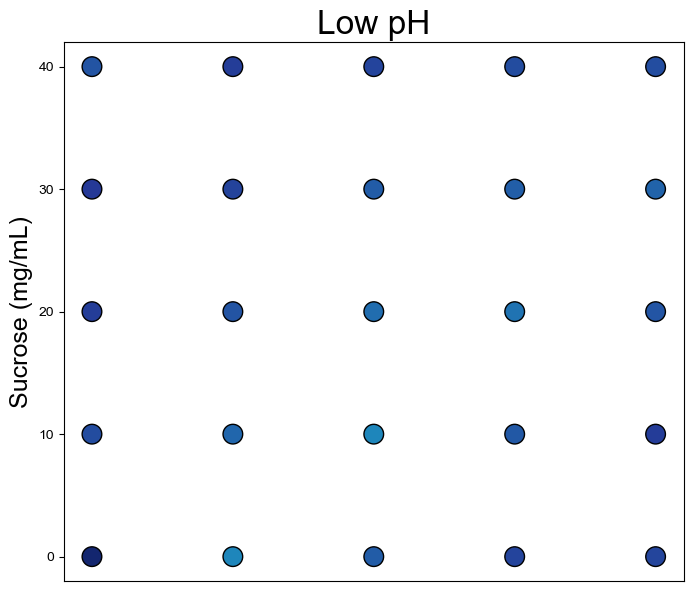

In [27]:
# Low pH Dot figures
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax1.scatter(batch_lo["Glucose"], batch_lo["Sucrose"], c=batch_lo["Fold Increase"], marker='o', edgecolors='k', linewidths=1.0, cmap='YlGnBu_r', s=200, vmin=0, vmax=33)
ax1.set_title("Low pH", fontsize=24)
ax1.set_ylabel('Sucrose (mg/mL)', fontsize=18)
ax1.set_xticks([])
ax1.set_yticks(np.arange(0,41,step=10),fontsize=24)

#Save figures (Activate this code and change the location if you want to save the file)
fig1.savefig('Low_pH_dot.png', dpi=600, bbox_inches='tight')
# display(fig)


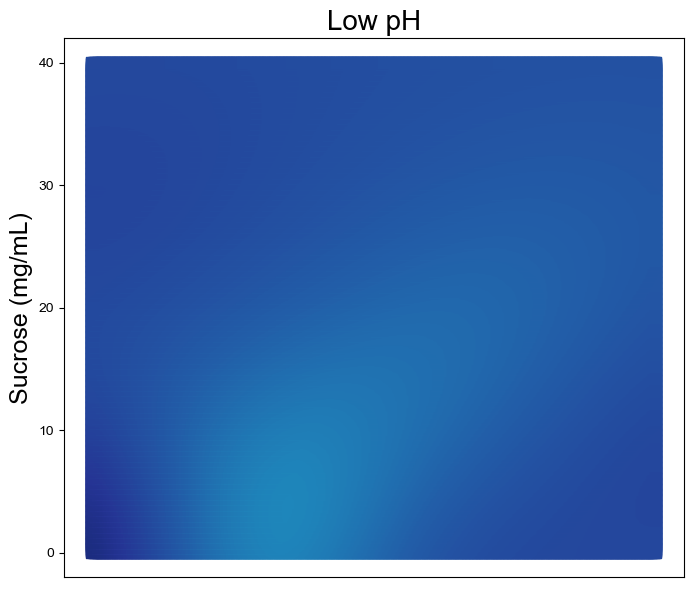

In [28]:
# Low pH Heatmap figures

fig2, ax2 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax2.scatter(X_nor * 40, Y_nor * 40, c=pred_lo, marker=',', cmap='YlGnBu_r', s=70, vmin=0, vmax=33)
ax2.set_title("Low pH", fontsize=24)
ax2.set_title("Low pH", fontsize=20)
ax2.set_ylabel('Sucrose (mg/mL)', fontsize=18)
ax2.set_xticks([])
ax2.set_yticks(np.arange(0,41,step=10),fontsize=24)

#Save figures (Activate this code and change the location if you want to save the file)
fig2.savefig('Low_pH_Heatmap.png', dpi=600, bbox_inches='tight')

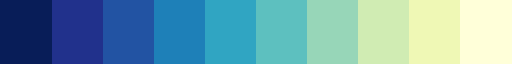

In [29]:
# Fetch the 'magma' colormap
magma_cmap = plt.colormaps['YlGnBu_r']

# Number of segments
n_segments = 10

# Define the range of the colormap
color_range = np.linspace(0, 1, n_segments)

# Get colors from the colormap
colors = [magma_cmap(x) for x in color_range]

# Define the new colormap name
cmap_name = 'segmented_magma'

# Create a LinearSegmentedColormap from the list of colors
seg_magma = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_segments)
seg_magma

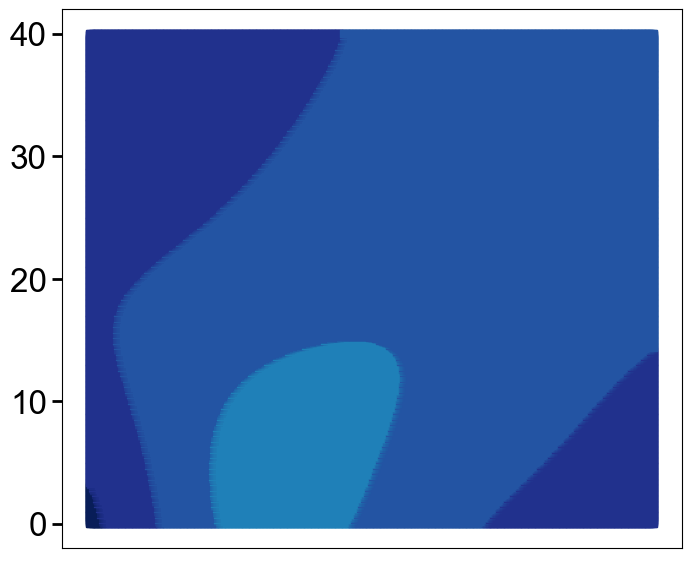

In [30]:
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax3.scatter(X_nor * 40, Y_nor * 40, c=pred_lo, marker=',', cmap=seg_magma, s=30, vmin=0, vmax=33)
ax3.set_yticks(np.arange(0,50,10))
ax3.set_xticks([])
ax3.set_yticklabels(np.arange(0,50,10), fontsize=24)
ax3.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    length=7,
    width=2) # labels along the bottom edge are off

#Save figures (Activate this code and change the location if you want to save the file)
fig3.savefig('Low_pH_Seg.png', dpi=600, bbox_inches='tight')
# display(fig)

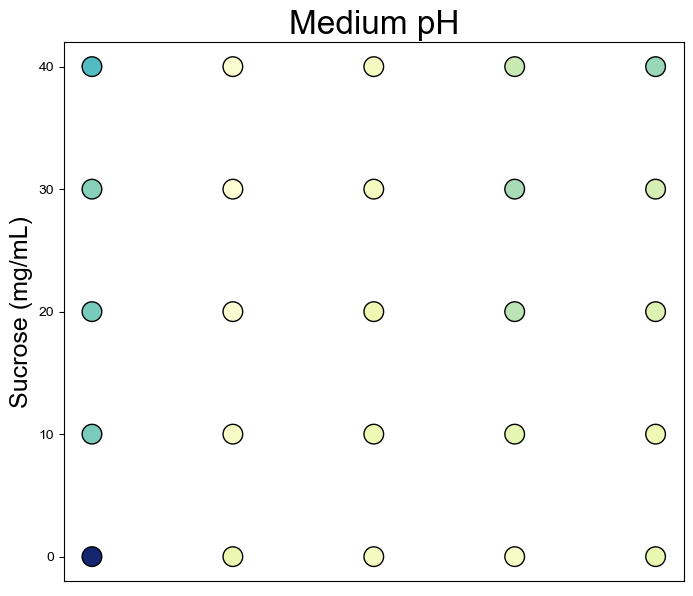

In [31]:
# Medium pH Dot figures
fig4, ax4 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax4.scatter(batch_md["Glucose"], batch_md["Sucrose"], c=batch_md["Fold Increase"], marker='o', edgecolors='k', linewidths=1, cmap='YlGnBu_r', s=200, vmin=0, vmax=33)
ax4.set_title("Medium pH", fontsize=24)
ax4.set_ylabel('Sucrose (mg/mL)', fontsize=18)
ax4.set_xticks([])
ax4.set_yticks(np.arange(0,41,step=10),fontsize=24)

#Save figures (Activate this code and change the location if you want to save the file)
fig4.savefig('Med_pH_Dot.png', dpi=600, bbox_inches='tight')
# display(fig)

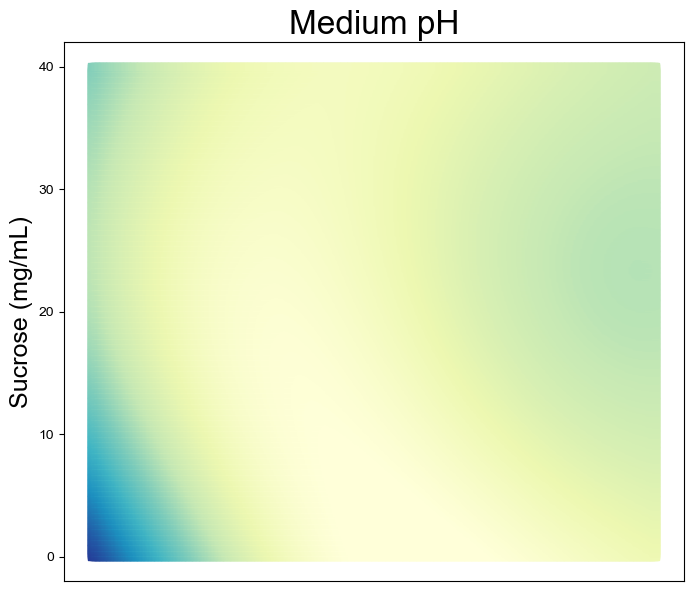

In [32]:
# Medium pH Heatmap figures
fig5, ax5 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax5.scatter(X_nor * 40, Y_nor * 40, c=pred_md, marker=',', cmap='YlGnBu_r', s=30, vmin=0, vmax=33)
ax5.set_title("Medium pH", fontsize=24)
ax5.set_ylabel('Sucrose (mg/mL)', fontsize=18)
ax5.set_xticks([])
ax5.set_yticks(np.arange(0,41,step=10),fontsize=24)

#Save figures (Activate this code and change the location if you want to save the file)
fig5.savefig('Med_pH_Heatmap.png', dpi=600, bbox_inches='tight')
# display(fig)

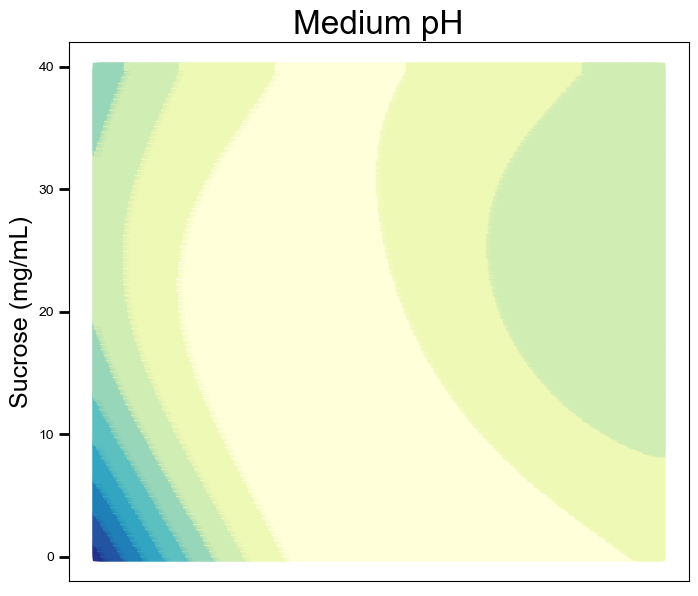

In [33]:
# Medium pH Segmented figures
fig6, ax6 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax6.scatter(X_nor * 40, Y_nor * 40, c=pred_md, marker=',', cmap=seg_magma, s=30, vmin=0, vmax=33)
ax6.set_title("Medium pH", fontsize=24)
ax6.set_ylabel('Sucrose (mg/mL)', fontsize=18)
ax6.set_xticks([])
ax6.set_yticks(np.arange(0,41,step=10),fontsize=24)
ax6.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    length=7,
    width=2) # labels along the bottom edge are off

#Save figures (Activate this code and change the location if you want to save the file)
fig6.savefig('Med_pH_Seg.png', dpi=600, bbox_inches='tight')



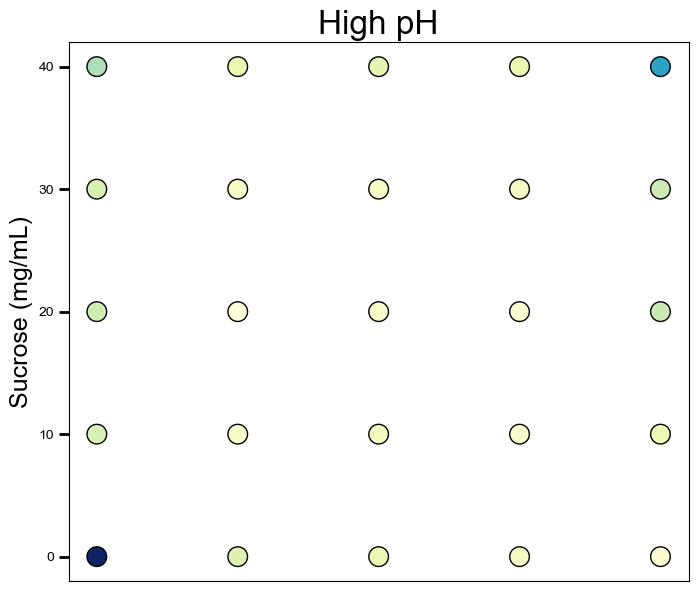

In [34]:
# High pH Dot figures
fig7, ax7 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax7.scatter(batch_hi["Glucose"], batch_hi["Sucrose"], c=batch_hi["Fold Increase"], marker='o', edgecolors='k', linewidths=1.0, cmap='YlGnBu_r', s=200, vmin=0, vmax=33)
ax7.set_title("High pH", fontsize=24)
ax7.set_ylabel('Sucrose (mg/mL)', fontsize=18)
ax7.set_xticks([])
ax7.set_yticks(np.arange(0,41,step=10),fontsize=24)
ax7.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    length=7,
    width=2) # labels along the bottom edge are off

#Save figures (Activate this code and change the location if you want to save the file)
fig7.savefig('High_pH_Dot.png', dpi=600, bbox_inches='tight')


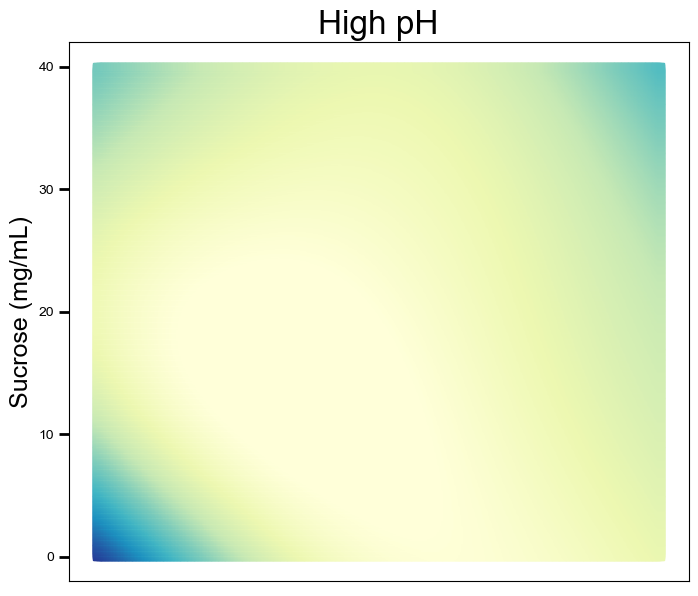

In [35]:
# High pH Heatmap figures
fig8, ax8 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax8.scatter(X_nor * 40, Y_nor * 40, c=pred_hi, marker=',', cmap='YlGnBu_r', s=30, vmin=0.0, vmax=33)
ax8.set_title("High pH", fontsize=24)
ax8.set_ylabel('Sucrose (mg/mL)', fontsize=18)
ax8.set_xticks([])
ax8.set_yticks(np.arange(0,41,step=10),fontsize=24)
ax8.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    length=7,
    width=2) # labels along the bottom edge are off

#Save figures (Activate this code and change the location if you want to save the file)
fig8.savefig('High_pH_Heatmap.png', dpi=600, bbox_inches='tight')

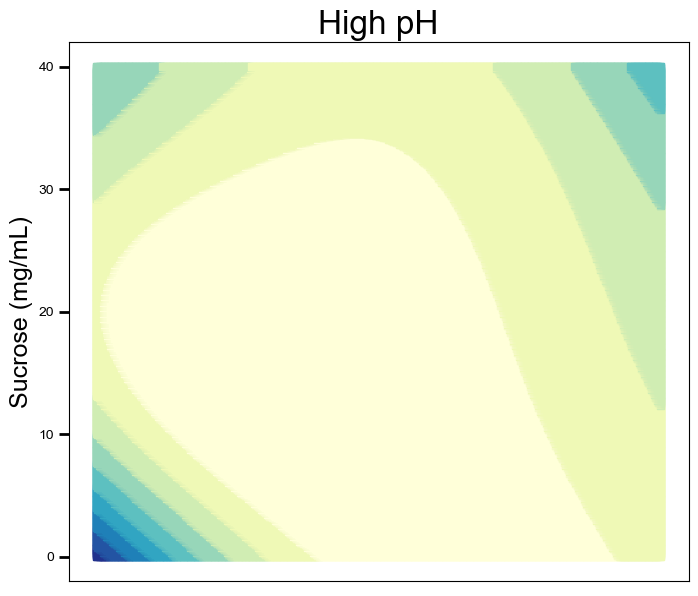

In [36]:
# High pH Heatmap figures
fig9, ax9 = plt.subplots(1, 1, figsize=(8, 7))
sc = ax9.scatter(X_nor * 40, Y_nor * 40, c=pred_hi, marker=',', cmap=seg_magma, s=30, vmin=0, vmax=33)
ax9.set_title("High pH", fontsize=24)
ax9.set_ylabel('Sucrose (mg/mL)', fontsize=18)
ax9.set_xticks([])
ax9.set_yticks(np.arange(0,41,step=10),fontsize=24)
ax9.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    length=7,
    width=2) # labels along the bottom edge are off

#Save figures (Activate this code and change the location if you want to save the file)
fig9.savefig('High_pH_Seg.png', dpi=600, bbox_inches='tight')





